# Sentiment Analysis Using Deep Learning

- Word embedding
- Visualising word embedding with t-SNE and nearest neighbours
- LSTM
- Stacking LSTM layers
- Bidirectional LSTM layers
- 1D convnet 
- 1D convnet + LSTM

In [1]:
import os
import numpy as np
import time

import smart_open
from tqdm.notebook import tqdm

from tensorflow.keras import models, layers, regularizers, preprocessing, optimizers
# to use TensorBoard, import tensorflow.keras.callbacks not keras.callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import gensim

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
N_FREQ_WORD = 10000  # use only the top 10,000 most frequently occurring words
EMBEDDING_OP_DIM = 100  # embedding output dim
TRAIN_PATH = '../input/aclimdb/aclImdb/train/'
TEST_PATH = '../input/aclimdb/aclImdb/test/'
GLOVE_PATH = '../input/glove6b/glove.6B.100d.txt'
MODEL_CHECKPOINT_DIR = '../working/model_checkpoint'
TENSOR_BOARD_DIR = '../working/tensor_board_dir'

# callback
EARLY_STOPPING = {
    'monitor': 'val_acc',  # monitor the validation accuracy of the model
                           # 'acc' must be in compile metrics
    'patience': 2,  # Training will be interrupted when the accuracy
                    # has stopped improving for *more* than 2 epochs
}
MODEL_CHECKPOINT = {
    'monitor': 'val_loss',  # validation data must be supplied in fit
    'save_best_only': True,  # keep the best model ever seen during training.
}
REDUCE_LR_ON_PLATEAU = {
    'monitor': 'val_loss',
    'factor': 0.5,  # divide the learning by 2 when it gets triggered
    'patience': 2,  # triggered after the validation loss has stopped 
                    # improving for at least 2 epochs
}
TENSOR_BOARD = {
    'log_dir': TENSOR_BOARD_DIR,
    'histogram_freq': 1,  # record activation histograms every 1 epoch
    'embeddings_freq': 1,  # record embedding data every 1 epoch
}

In [3]:
experiment = {}
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(TENSOR_BOARD_DIR, exist_ok=True)

In [4]:
def plot_metric_vs_epochs(data, ax=None, figsize=(16, 5), **set_kwargs):
    """
    data : dict
        A dictionary of data
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    for data_label, data_points in data.items():
        epochs = range(1, len(data_points)+1)
        ax.plot(epochs, data_points, label=data_label)
        ax.legend()
        ax.set(**set_kwargs)

    return fig, ax


def plot_loss_acc(history, figsize=(16, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_metric_vs_epochs(data={k: v for (k, v) in history.history.items() if k in ['loss', 'val_loss']},
                          ax=ax[0],
                          title='Training and validation loss',
                          xlabel='Epochs', 
                          ylabel='Loss')

    plot_metric_vs_epochs(data={k: v for (k, v) in history.history.items() if k in ['acc', 'val_acc']},
                          ax=ax[1],
                          title='Training and validation accuracy',
                          xlabel='Epochs', 
                          ylabel='Accuracy')

    plt.show()
    return fig, ax


def load_dataset(path):
    texts, labels = [], []
    
    for i, label_type in enumerate(['neg', 'pos']):
        dir_name = os.path.join(path, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r') as f:
                    texts.append(f.read())
                    
                labels.append(i)
                
    return texts, labels


def prepare_dataset(X, y, max_features, test_size, max_seq_len='auto', random_state=None):
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    tokenizer = preprocessing.text.Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(X_train)
    seq_X_train = tokenizer.texts_to_sequences(X_train)
    seq_X_val = tokenizer.texts_to_sequences(X_val)
    
    if max_seq_len == 'auto':
        seq_len = [len(x) for x in seq_X_train]
        max_seq_len = int(np.round(np.mean(seq_len)))
        print(f'Automatically selecting maximum sequence length: {max_seq_len}')
    elif max_seq_len == 'max':
        seq_len = [len(x) for x in seq_X_train]
        max_seq_len = max(seq_len)
        print(f'Selecting maximum sequence length at max length of training set: {max_seq_len}')
    
    seq_X_train_pad = preprocessing.sequence.pad_sequences(
        seq_X_train, maxlen=max_seq_len, padding='pre', truncating='post')
    seq_X_val_pad = preprocessing.sequence.pad_sequences(
        seq_X_val, maxlen=max_seq_len, padding='pre', truncating='post')
    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
    
    # collect only the select word and index
    word_index = {w:idx for w, idx in tokenizer.word_index.items() if idx <= max_features}
    
    return (seq_X_train_pad, seq_X_val_pad, y_train, y_val), word_index


def get_dataset(path, max_features, test_size, max_seq_len='auto', random_state=None):
    X, y = load_dataset(path)
    (X_train, X_val, y_train, y_val), word_index = \
        prepare_dataset(X, y, max_features, test_size, max_seq_len, random_state)
    return X_train, X_val, y_train, y_val, word_index


def load_embedding_index(path):
    """Store embedding in dictionary for efficient access"""
    embedding_index = {}
    with open(path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    
    # assuming all embedding vectors have the same dimension
    embedding_dim = embedding_index[next(iter(embedding_index))].shape[0]
    
    return embedding_index, embedding_dim


def create_embedding_matrix(embedding_index, embedding_dim, word_index, max_features):
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if i < max_features:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    return embedding_matrix


def display_exp_summary(experiment):
    print('model | val acc | duration')
    for name, exp in experiment.items():
        val_acc = exp['history'].history['val_acc'][-1]
        dur = exp['duration']
        print(f"{name} | {val_acc:.3g} | {dur:.3g}s")
        
        
def get_word_embedding(embedding_layer, word_index):
    embeddings = embedding_layer.get_weights()[0]
    return {w:embeddings[idx-1] for w, idx in word_index.items()}


def plot_embedding_tsne(embedding, perplexity=40, n_components=2, init='pca', n_iter=2500, 
                        random_state=0, figsize=(16, 16), **kwargs):
    word_list = []
    vector_list = []

    for word, vector in embedding.items():
        word_list.append(word)
        vector_list.append(vector)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=n_components, init=init, 
                      n_iter=n_iter, random_state=random_state, **kwargs)
    new_values = tsne_model.fit_transform(vector_list)
        
    fig, ax = plt.subplots(figsize=figsize) 
    for i, (x_new, y_new) in enumerate(new_values):
        ax.scatter(x_new, y_new)
        ax.annotate(word_list[i],
                    xy=(x_new, y_new),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    
    return fig


def save_word2vec_format(fname, vocab, vector_size, binary=True):
    """Store the input-hidden weight matrix in the same format used by the original
    C word2vec-tool, for compatibility.

    Parameters
    ----------
    fname : str
        The file path used to save the vectors in.
    vocab : dict
        The vocabulary of words.
    vector_size : int
        The number of dimensions of word vectors.
    binary : bool, optional
        If True, the data wil be saved in binary word2vec format, else it will be saved in plain text.


    """
    
    total_vec = len(vocab)
    with smart_open.open(fname, 'wb') as fout:
        print(total_vec, vector_size)
        fout.write(gensim.utils.to_utf8("%s %s\n" % (total_vec, vector_size)))
        # store in sorted order: most frequent words at the top
        for word, row in tqdm(vocab.items()):
            if binary:
                row = row.astype(np.float32)
                fout.write(gensim.utils.to_utf8(word) + b" " + row.tostring())
            else:
                fout.write(gensim.utils.to_utf8("%s %s\n" % (word, ' '.join(repr(val) for val in row))))

In [5]:
X_train, X_val, y_train, y_val, word_index = \
    get_dataset(path=TRAIN_PATH,
                max_features=N_FREQ_WORD, 
                test_size=0.3, 
                max_seq_len=300, 
                random_state=0)

`word_index`: lower the number the more frequent a word is.

In [6]:
word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'he': 27,
 'one': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'who': 34,
 'so': 35,
 'from': 36,
 'like': 37,
 'her': 38,
 'or': 39,
 'just': 40,
 'about': 41,
 'out': 42,
 "it's": 43,
 'has': 44,
 'if': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'more': 50,
 'when': 51,
 'very': 52,
 'up': 53,
 'she': 54,
 'even': 55,
 'time': 56,
 'no': 57,
 'my': 58,
 'would': 59,
 'which': 60,
 'only': 61,
 'story': 62,
 'really': 63,
 'see': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'were': 68,
 'me': 69,
 'well': 70,
 'than': 71,
 'we': 72,
 'much': 73,
 'will': 74,
 'bad': 75,
 'get': 76,
 'been': 77,
 'do': 78,
 'people': 79,
 'other': 80,
 'also': 81,
 'because': 82,

In [7]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(len(word_index))

(17500, 300)
(7500, 300)
(17500,)
(7500,)
10000


## Train customised word embedding 

In [8]:
def build_dense_model(embedding_matrix=None, **params):
    model = models.Sequential()
    model.add(layers.Embedding(**params['embedding']))
    model.add(layers.Flatten())
    model.add(layers.Dropout(**params['dropout']))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(**params['dropout']))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(**params['optimizer']),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [9]:
experiment_name = 'custom_embedding_dense'

experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': EMBEDDING_OP_DIM,
        'input_length': X_train.shape[1]
    },
    'dropout': {
        'rate': 0.5
    },
    'optimizer': {
        'lr': 0.001
    }
}

callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = build_dense_model(**params)
experiment[experiment_name]['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                960032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,960,065
Trainable params: 1,960,065
Non-trainable params: 0
______________________________________________

In [10]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 8s 462us/sample - loss: 0.5498 - acc: 0.6926 - val_loss: 0.3657 - val_acc: 0.8363
Epoch 2/30
17500/17500 [==============================] - 7s 376us/sample - loss: 0.2478 - acc: 0.9007 - val_loss: 0.3729 - val_acc: 0.8515
Epoch 3/30
17500/17500 [==============================] - 7s 400us/sample - loss: 0.1166 - acc: 0.9586 - val_loss: 0.3974 - val_acc: 0.8691
Epoch 4/30
17500/17500 [==============================] - 7s 386us/sample - loss: 0.0455 - acc: 0.9845 - val_loss: 0.4609 - val_acc: 0.8716
Epoch 5/30
17500/17500 [==============================] - 6s 358us/sample - loss: 0.0308 - acc: 0.9901 - val_loss: 0.5309 - val_acc: 0.8696
Epoch 6/30
17500/17500 [==============================] - 6s 365us/sample - loss: 0.0166 - acc: 0.9952 - val_loss: 0.5581 - val_acc: 0.8705


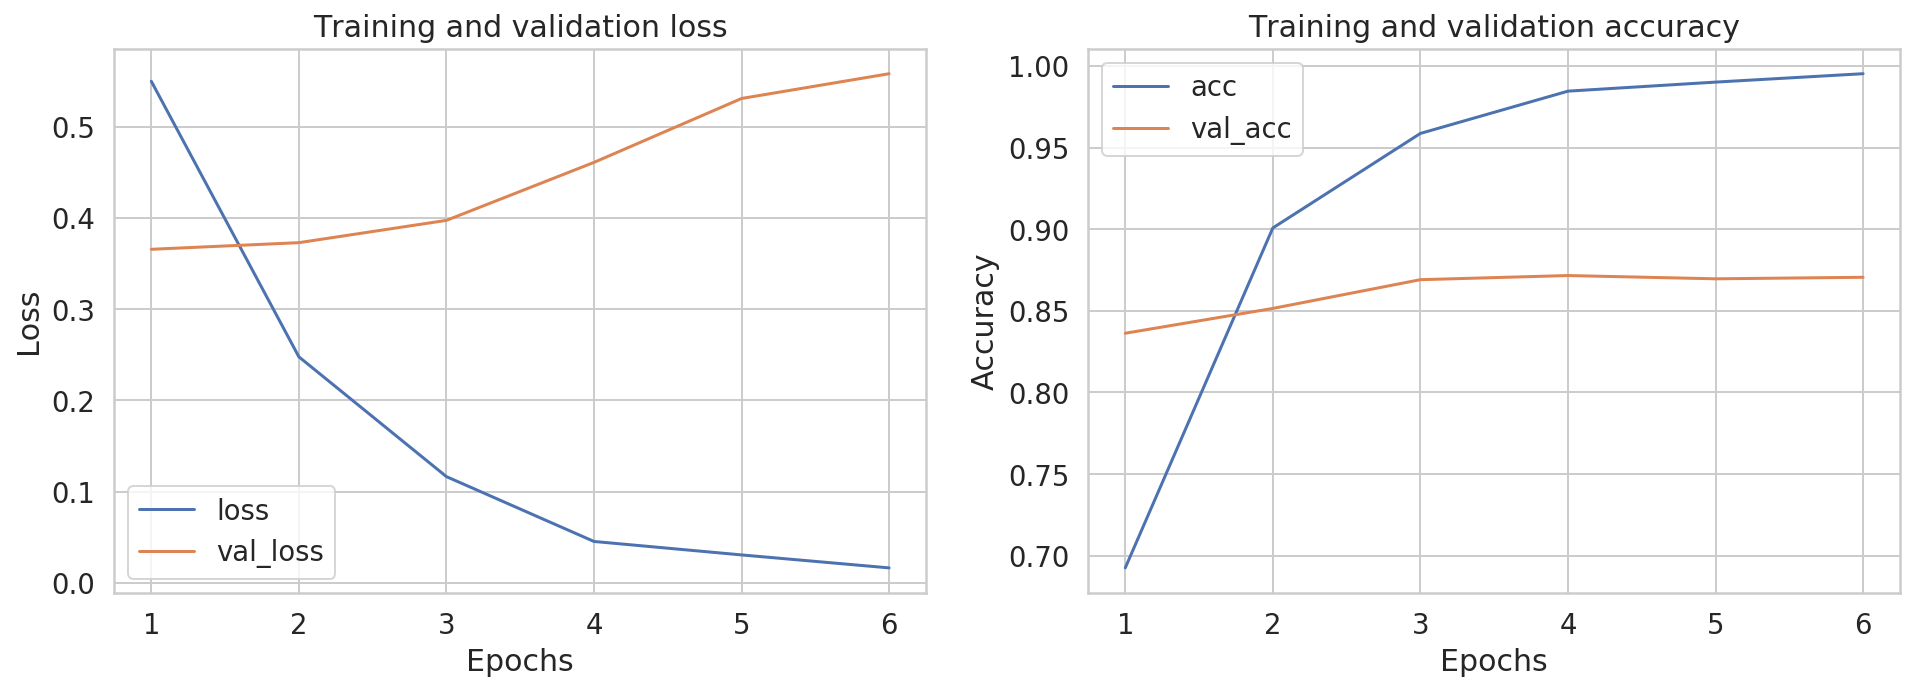

In [11]:
# experiment_name = 'custom_embedding_dense'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [12]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s


## Using GloVe embedding

In [13]:
embedding_index, embedding_dim = load_embedding_index(path=GLOVE_PATH)
embedding_matrix = create_embedding_matrix(embedding_index, embedding_dim, word_index, N_FREQ_WORD)

In [14]:
experiment_name = 'pretrain_embedding_dense'
experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': embedding_dim,
        'weights': [embedding_matrix],
        'input_length': X_train.shape[1],
        'trainable': False
    },
    'dropout': {
        'rate': 0.5
    },
    'optimizer': {
        'lr': 0.001
    }
}

callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = \
    build_dense_model(embedding_matrix=embedding_matrix, **params)
experiment[experiment_name]['model'].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                960032    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,960,065
Trainable params: 960,065
Non-trainable params: 1,000,000
______________________________________

In [15]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 4s 257us/sample - loss: 0.7125 - acc: 0.4977 - val_loss: 0.6921 - val_acc: 0.5141
Epoch 2/30
17500/17500 [==============================] - 4s 212us/sample - loss: 0.6954 - acc: 0.5095 - val_loss: 0.6877 - val_acc: 0.5287
Epoch 3/30
17500/17500 [==============================] - 4s 236us/sample - loss: 0.6947 - acc: 0.5187 - val_loss: 0.6775 - val_acc: 0.5729
Epoch 4/30
17500/17500 [==============================] - 4s 229us/sample - loss: 0.6880 - acc: 0.5655 - val_loss: 0.6625 - val_acc: 0.6567
Epoch 5/30
17500/17500 [==============================] - 4s 231us/sample - loss: 0.6536 - acc: 0.6220 - val_loss: 0.6200 - val_acc: 0.6789
Epoch 6/30
17500/17500 [==============================] - 4s 228us/sample - loss: 0.6200 - acc: 0.6525 - val_loss: 0.6113 - val_acc: 0.6783
Epoch 7/30
17500/17500 [==============================] - 4s 219us/sample - loss: 0.5951 - acc: 0.6814 - val_lo

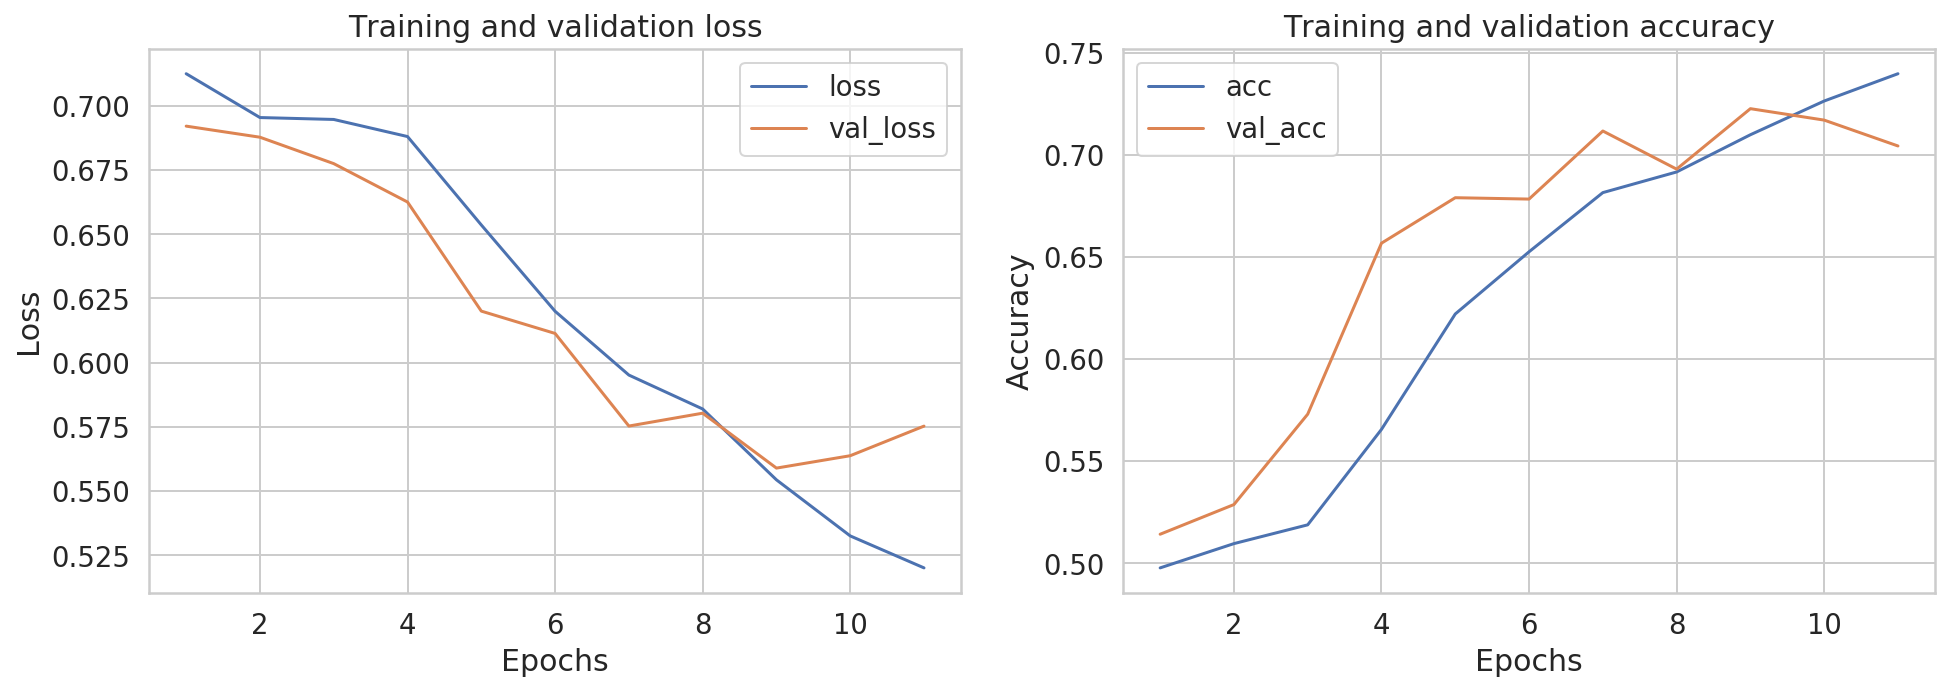

In [16]:
experiment_name = 'pretrain_embedding_dense'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [17]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s
pretrain_embedding_dense | 0.704 | 43.8s


## LSTM

In [18]:
def build_lstm_model(embedding_matrix=None, **params):
    model = models.Sequential()
    model.add(layers.Embedding(**params['embedding']))
    model.add(layers.LSTM(**params['lstm']))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(**params['optimizer']),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [19]:
experiment_name = 'custom_embedding_lstm'
experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': 100,
        'input_length': X_train.shape[1]
    },
    'lstm': {
        'units': 32,
        'dropout': 0.2,
        'recurrent_dropout': 0.2
    },
    'optimizer': {
        'lr': 0.001
    }
}

callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = build_lstm_model(**params)
experiment[experiment_name]['model'].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [20]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 342s 20ms/sample - loss: 0.5034 - acc: 0.7615 - val_loss: 0.3902 - val_acc: 0.8345
Epoch 2/30
17500/17500 [==============================] - 335s 19ms/sample - loss: 0.3518 - acc: 0.8572 - val_loss: 0.3473 - val_acc: 0.8604
Epoch 3/30
17500/17500 [==============================] - 332s 19ms/sample - loss: 0.3015 - acc: 0.8794 - val_loss: 0.3444 - val_acc: 0.8720
Epoch 4/30
17500/17500 [==============================] - 330s 19ms/sample - loss: 0.2740 - acc: 0.8938 - val_loss: 0.3328 - val_acc: 0.8648
Epoch 5/30
17500/17500 [==============================] - 331s 19ms/sample - loss: 0.2476 - acc: 0.9077 - val_loss: 0.3546 - val_acc: 0.8552


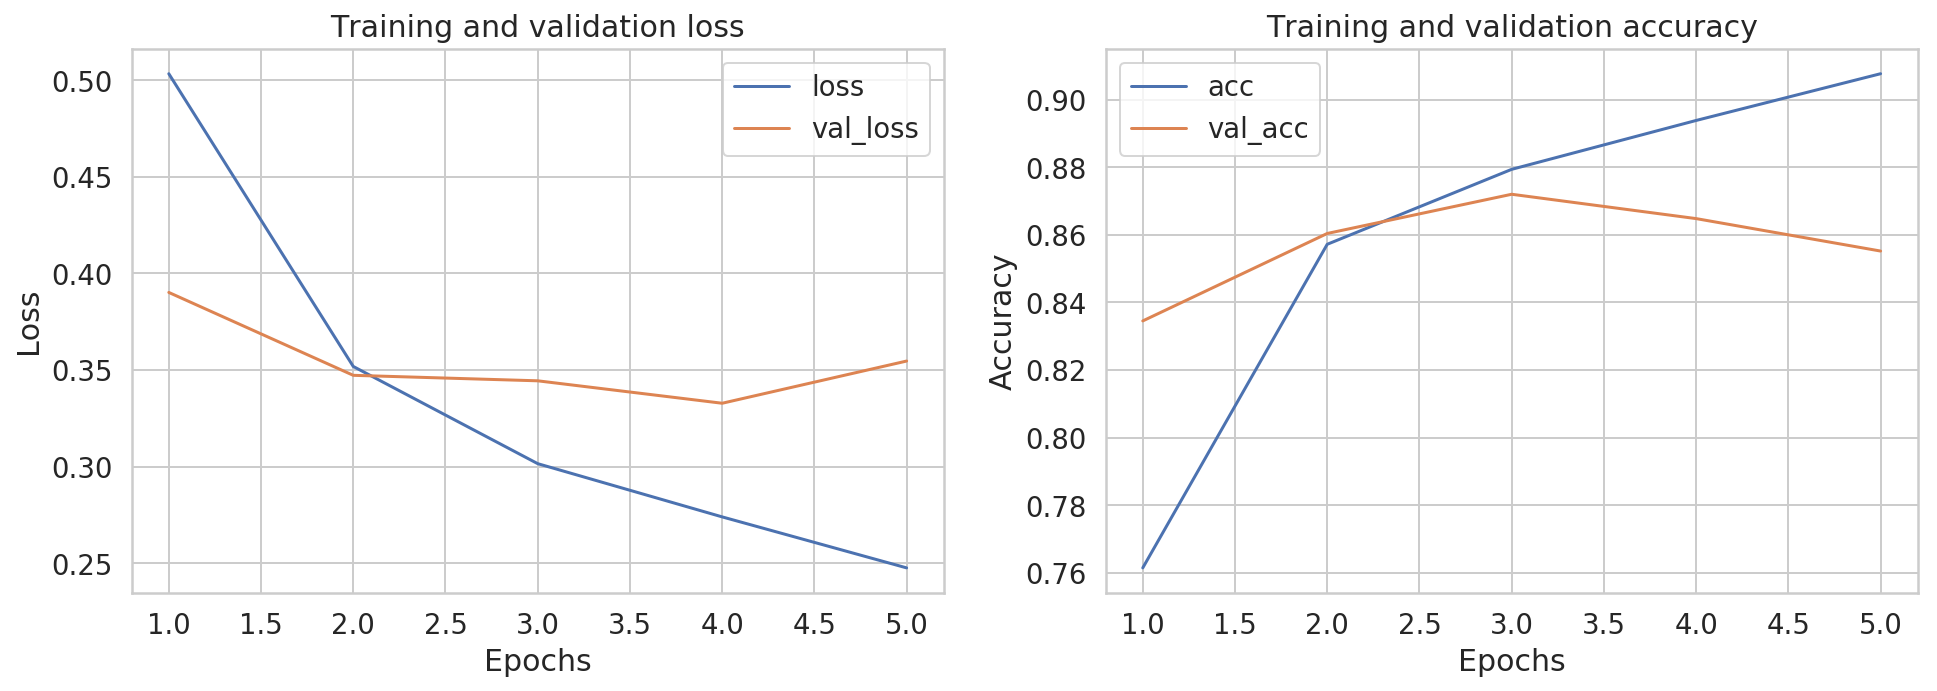

In [21]:
experiment_name = 'custom_embedding_lstm'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [22]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s
pretrain_embedding_dense | 0.704 | 43.8s
custom_embedding_lstm | 0.855 | 1.67e+03s


## Stacking recurrent layers

In [23]:
def build_stack_model(embedding_matrix=None, **params):
    model = models.Sequential()
    
    model.add(layers.Embedding(**params['embedding']))
    
    # all intermediate recurrent layers should return their full sequence of outputs
    model.add(layers.LSTM(return_sequences=True, **params['lstm_1']))
    
    model.add(layers.LSTM(**params['lstm_2']))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(**params['optimizer']),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [24]:
experiment_name = 'custom_embedding_stack_lstm'
experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': 100,
        'input_length': X_train.shape[1]
    },
    'lstm_1': {
        'units': 32,
        'dropout': 0.3,
        'recurrent_dropout': 0.3
    },
    'lstm_2': {
        'units': 64,
        # 'activation': 'relu',
        'dropout': 0.3,
        'recurrent_dropout': 0.3
    },
    'optimizer': {
        'lr': 0.001
    }
}


callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = build_stack_model(**params)
experiment[experiment_name]['model'].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           17024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,041,921
Trainable params: 1,041,921
Non-trainable params: 0
_________________________________________________________________


In [25]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 649s 37ms/sample - loss: 0.4967 - acc: 0.7627 - val_loss: 0.3814 - val_acc: 0.8412
Epoch 2/30
17500/17500 [==============================] - 640s 37ms/sample - loss: 0.3553 - acc: 0.8554 - val_loss: 0.3425 - val_acc: 0.8627
Epoch 3/30
17500/17500 [==============================] - 641s 37ms/sample - loss: 0.2993 - acc: 0.8831 - val_loss: 0.3661 - val_acc: 0.8504
Epoch 4/30
17500/17500 [==============================] - 638s 36ms/sample - loss: 0.2606 - acc: 0.9019 - val_loss: 0.3305 - val_acc: 0.8737
Epoch 5/30
17500/17500 [==============================] - 636s 36ms/sample - loss: 0.2395 - acc: 0.9111 - val_loss: 0.3637 - val_acc: 0.8644
Epoch 6/30
17500/17500 [==============================] - 642s 37ms/sample - loss: 0.2230 - acc: 0.9184 - val_loss: 0.3036 - val_acc: 0.8829
Epoch 7/30
17500/17500 [==============================] - 639s 36ms/sample - loss: 0.2135 - acc: 0.9213 -

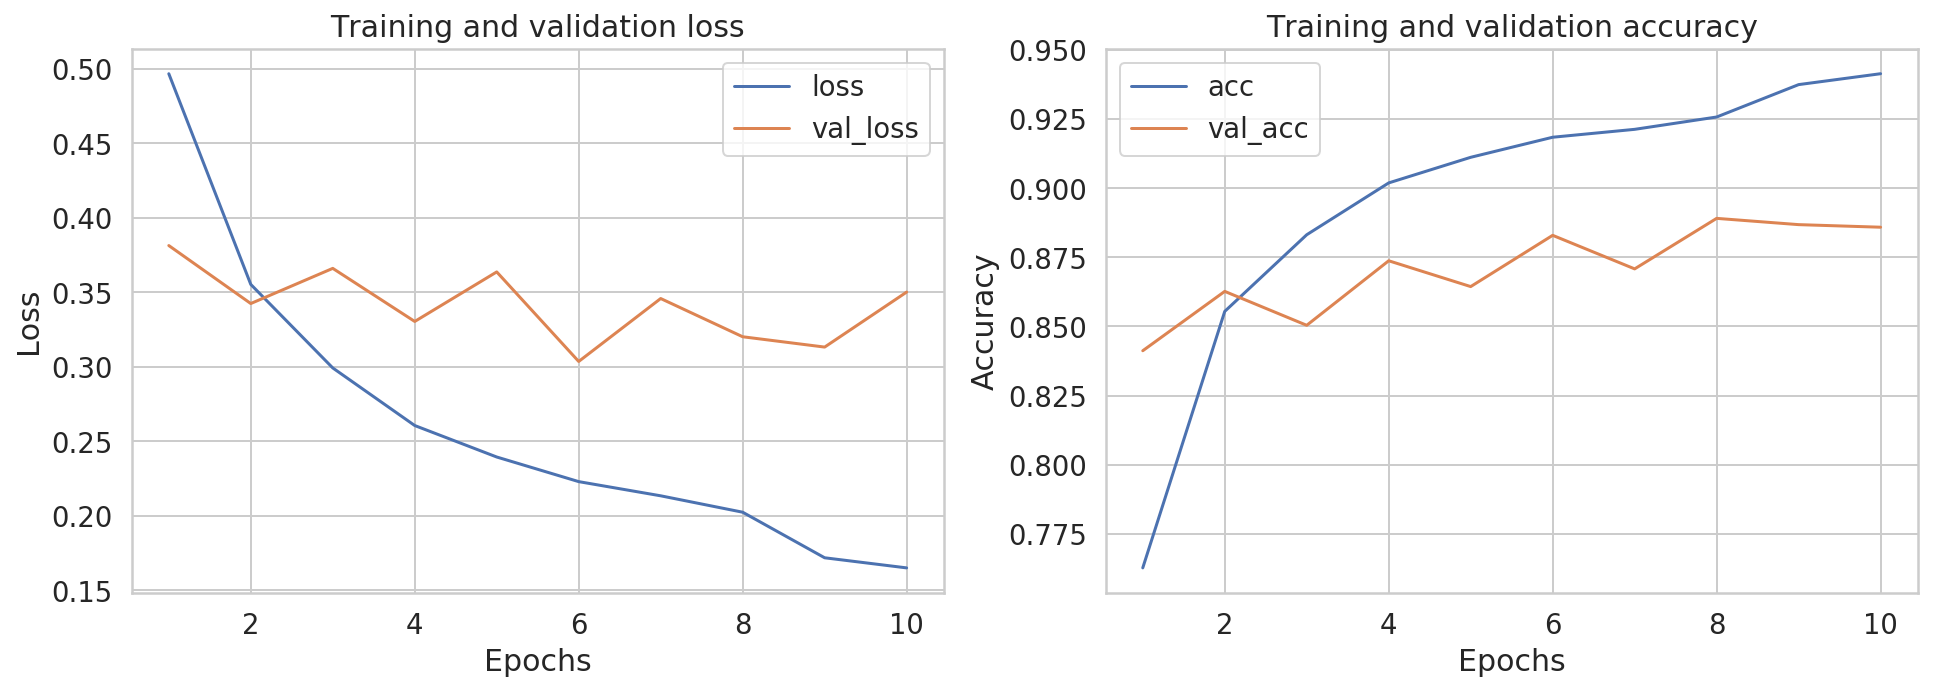

In [26]:
experiment_name = 'custom_embedding_stack_lstm'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [27]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s
pretrain_embedding_dense | 0.704 | 43.8s
custom_embedding_lstm | 0.855 | 1.67e+03s
custom_embedding_stack_lstm | 0.886 | 6.4e+03s


## Bidirectional layers

In [28]:
def build_bidirectional_model(embedding_matrix=None, **params):
    model = models.Sequential()
    
    model.add(layers.Embedding(**params['embedding']))
    
    model.add(layers.Bidirectional(layers.LSTM(**params['lstm'])))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(**params['optimizer']),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [29]:
experiment_name = 'custom_embedding_bidir_lstm'
experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': 100,
        'input_length': X_train.shape[1]
    },
    'lstm': {
        'units': 32,
        'dropout': 0.2,
        'recurrent_dropout': 0.2
    },
    'optimizer': {
        'lr': 0.001
    }
}

callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = build_bidirectional_model(**params)
experiment[experiment_name]['model'].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,034,113
Trainable params: 1,034,113
Non-trainable params: 0
_________________________________________________________________


In [30]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 665s 38ms/sample - loss: 0.5078 - acc: 0.7548 - val_loss: 0.3828 - val_acc: 0.8420
Epoch 2/30
17500/17500 [==============================] - 663s 38ms/sample - loss: 0.3589 - acc: 0.8538 - val_loss: 0.3759 - val_acc: 0.8447
Epoch 3/30
17500/17500 [==============================] - 661s 38ms/sample - loss: 0.3049 - acc: 0.8767 - val_loss: 0.3351 - val_acc: 0.8643
Epoch 4/30
17500/17500 [==============================] - 664s 38ms/sample - loss: 0.2685 - acc: 0.8967 - val_loss: 0.3171 - val_acc: 0.8775
Epoch 5/30
17500/17500 [==============================] - 663s 38ms/sample - loss: 0.2350 - acc: 0.9109 - val_loss: 0.3196 - val_acc: 0.8777
Epoch 6/30
17500/17500 [==============================] - 662s 38ms/sample - loss: 0.2176 - acc: 0.9167 - val_loss: 0.3588 - val_acc: 0.8732
Epoch 7/30
17500/17500 [==============================] - 664s 38ms/sample - loss: 0.1842 - acc: 0.9335 -

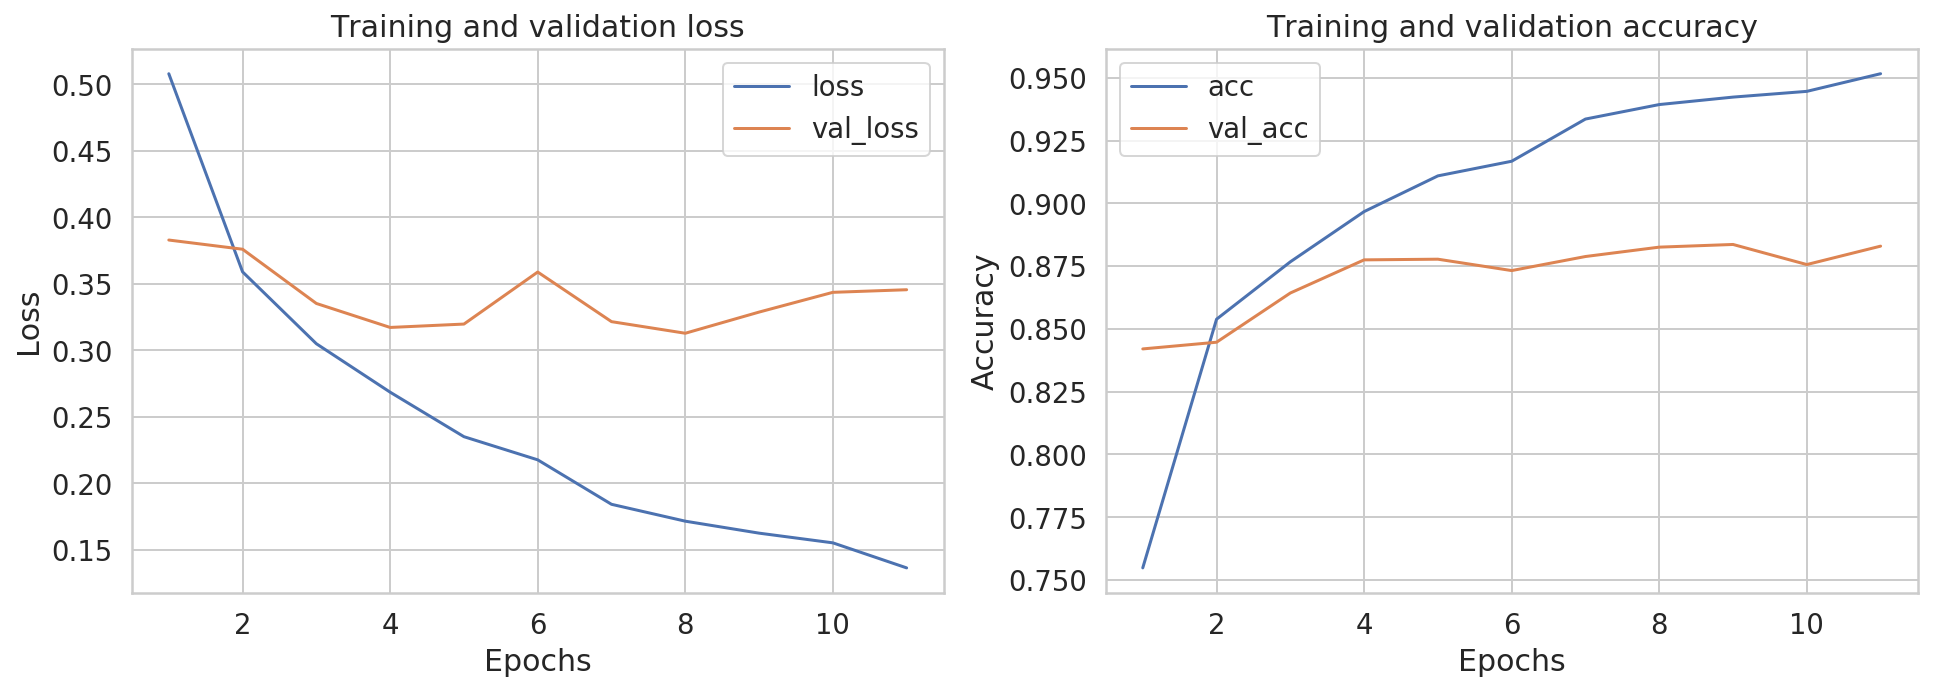

In [31]:
experiment_name = 'custom_embedding_bidir_lstm'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [32]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s
pretrain_embedding_dense | 0.704 | 43.8s
custom_embedding_lstm | 0.855 | 1.67e+03s
custom_embedding_stack_lstm | 0.886 | 6.4e+03s
custom_embedding_bidir_lstm | 0.883 | 7.29e+03s


## 1D convnet

In [33]:
def build_convnet_model(embedding_matrix=None, **params):
    model = models.Sequential()
    
    model.add(layers.Embedding(**params['embedding']))
    
    model.add(layers.Conv1D(**params['conv_1']))
    model.add(layers.MaxPooling1D(**params['max_pooling']))
    
    model.add(layers.Conv1D(**params['conv_2']))
    model.add(layers.GlobalMaxPooling1D())
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(**params['optimizer']),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [34]:
experiment_name = 'custom_embedding_convnet'
experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': 100,
        'input_length': X_train.shape[1]
    },
    'conv_1': {
        'filters': 32, 
        'kernel_size': 7, 
        'activation': 'relu'
    },
    'max_pooling': {
        'pool_size': 7
    },
    'conv_2': {
        'filters': 32, 
        'kernel_size': 7, 
        'activation': 'relu'
    },
    'optimizer': {
        'lr': 0.001
    }
}

callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = build_convnet_model(**params)
experiment[experiment_name]['model'].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 294, 32)           22432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 42, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,029,665
Trainable params: 1,029,665
Non-trainable params: 0
____________________________________________

In [35]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 10s 599us/sample - loss: 0.4338 - acc: 0.7871 - val_loss: 0.3184 - val_acc: 0.8664
Epoch 2/30
17500/17500 [==============================] - 7s 380us/sample - loss: 0.2456 - acc: 0.9014 - val_loss: 0.2863 - val_acc: 0.8825
Epoch 3/30
17500/17500 [==============================] - 7s 403us/sample - loss: 0.1734 - acc: 0.9325 - val_loss: 0.3064 - val_acc: 0.8756
Epoch 4/30
17500/17500 [==============================] - 7s 397us/sample - loss: 0.1151 - acc: 0.9580 - val_loss: 0.3133 - val_acc: 0.8867
Epoch 5/30
17500/17500 [==============================] - 7s 410us/sample - loss: 0.0526 - acc: 0.9855 - val_loss: 0.3532 - val_acc: 0.8791
Epoch 6/30
17500/17500 [==============================] - 7s 379us/sample - loss: 0.0272 - acc: 0.9939 - val_loss: 0.3646 - val_acc: 0.8787


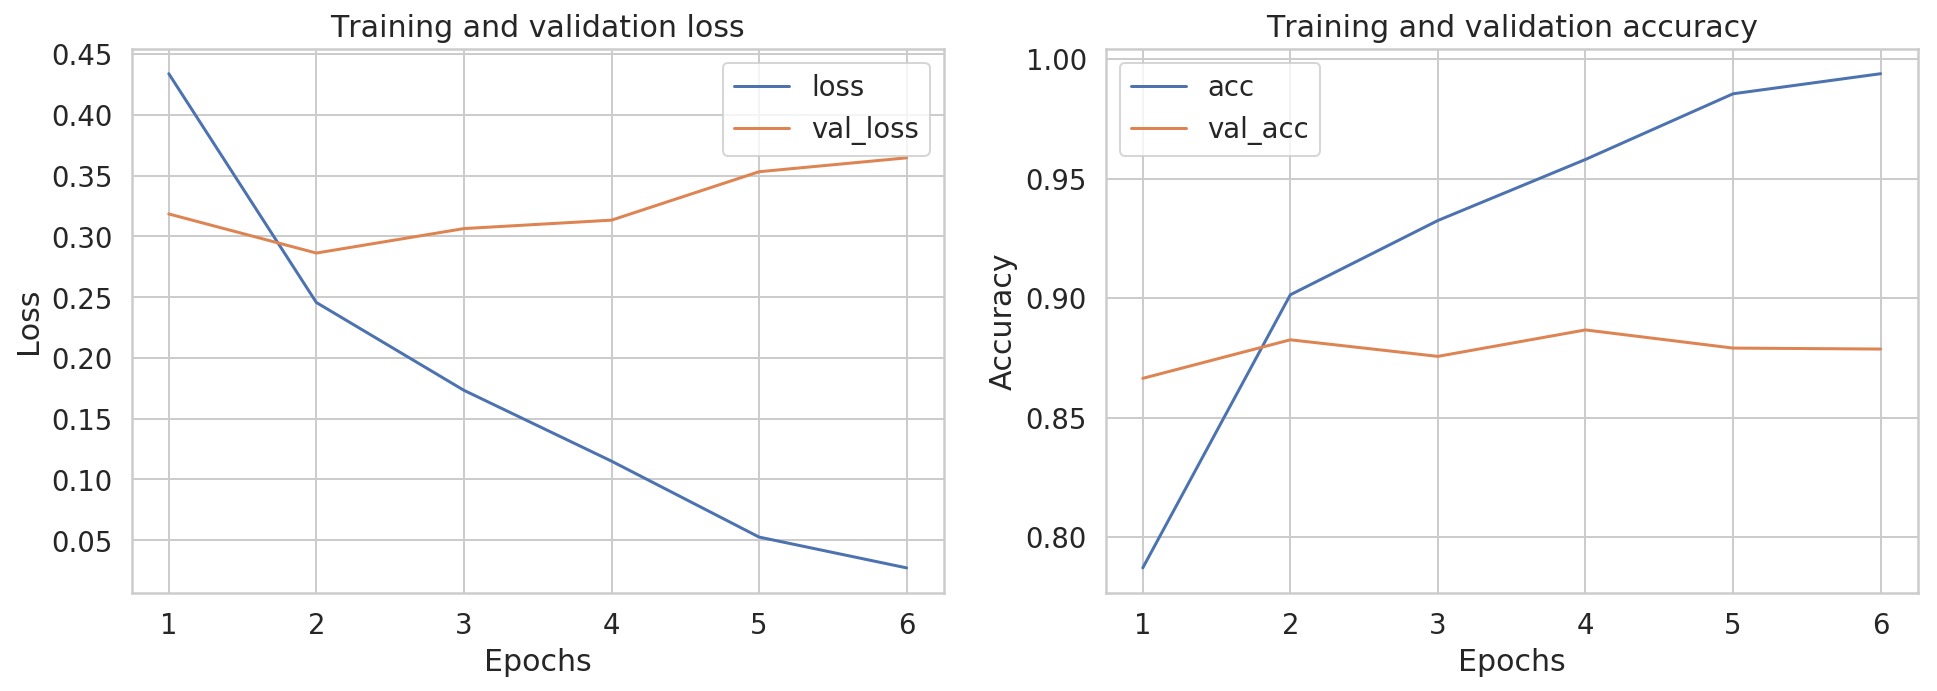

In [36]:
experiment_name = 'custom_embedding_convnet'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [37]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s
pretrain_embedding_dense | 0.704 | 43.8s
custom_embedding_lstm | 0.855 | 1.67e+03s
custom_embedding_stack_lstm | 0.886 | 6.4e+03s
custom_embedding_bidir_lstm | 0.883 | 7.29e+03s
custom_embedding_convnet | 0.879 | 45.2s


## 1D convnet + LSTM

In [38]:
def build_convnet_lstm_model(embedding_matrix=None, **params):
    model = models.Sequential()
    
    model.add(layers.Embedding(**params['embedding']))
    
    model.add(layers.Conv1D(**params['conv_1']))
    model.add(layers.MaxPooling1D(**params['max_pooling']))
    
    model.add(layers.LSTM(**params['lstm']))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(**params['optimizer']),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [39]:
experiment_name = 'custom_embedding_convnet_lstm'
experiment[experiment_name] = dict()

params = {
    'embedding': {
        'input_dim': N_FREQ_WORD,
        'output_dim': 100,
        'input_length': X_train.shape[1]
    },
    'conv_1': {
        'filters': 32, 
        'kernel_size': 7, 
        'activation': 'relu'
    },
    'max_pooling': {
        'pool_size': 7
    },
    'lstm': {
        'units': 32,
        'dropout': 0.2,
        'recurrent_dropout': 0.2
    },
    'optimizer': {
        'lr': 0.001
    }
}

callbacks_list = [
    EarlyStopping(**EARLY_STOPPING),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_CHECKPOINT_DIR, f'{experiment_name}.h5'),
        **MODEL_CHECKPOINT
    ),
    ReduceLROnPlateau(**REDUCE_LR_ON_PLATEAU),
    TensorBoard(**TENSOR_BOARD),
]

experiment[experiment_name]['model'] = build_convnet_lstm_model(**params)
experiment[experiment_name]['model'].summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 294, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 42, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,030,785
Trainable params: 1,030,785
Non-trainable params: 0
_________________________________________________________________


In [40]:
start = time.time()

experiment[experiment_name]['history'] = \
    experiment[experiment_name]['model']\
         .fit(X_train,
              y_train,
              epochs=30,
              batch_size=32,
              callbacks=callbacks_list,
              validation_data=(X_val, y_val))

experiment[experiment_name]['duration'] = time.time() - start

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 53s 3ms/sample - loss: 0.4160 - acc: 0.8022 - val_loss: 0.2918 - val_acc: 0.8815
Epoch 2/30
17500/17500 [==============================] - 50s 3ms/sample - loss: 0.2458 - acc: 0.9041 - val_loss: 0.2740 - val_acc: 0.8927
Epoch 3/30
17500/17500 [==============================] - 49s 3ms/sample - loss: 0.1917 - acc: 0.9282 - val_loss: 0.2816 - val_acc: 0.8888
Epoch 4/30
17500/17500 [==============================] - 50s 3ms/sample - loss: 0.1492 - acc: 0.9459 - val_loss: 0.2986 - val_acc: 0.8843


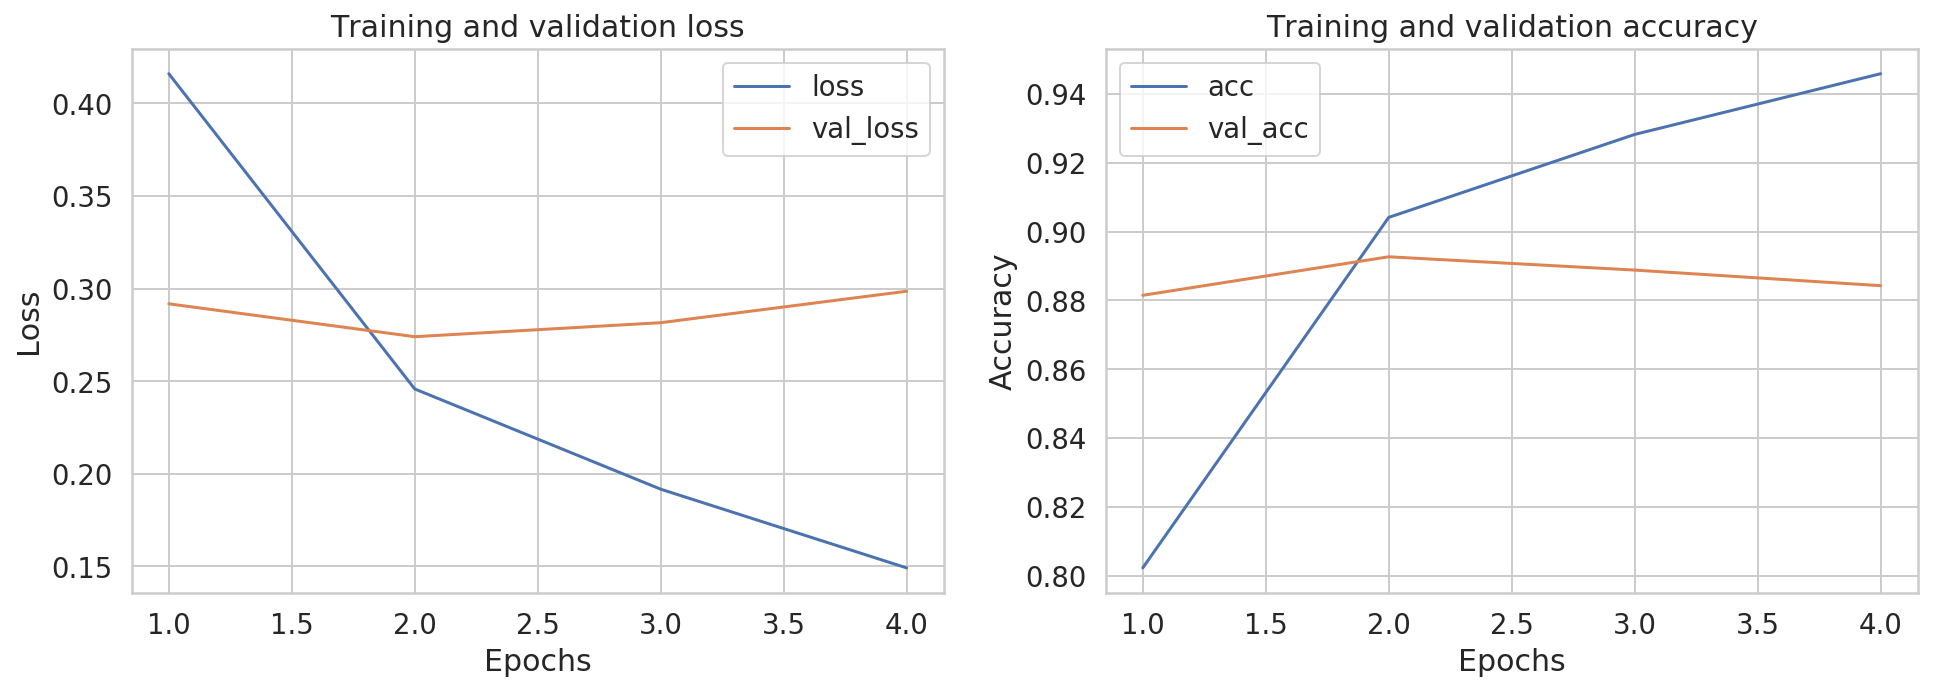

In [41]:
experiment_name = 'custom_embedding_convnet_lstm'
plot_loss_acc(experiment[experiment_name]['history'])
plt.show()

In [42]:
display_exp_summary(experiment)

model | val acc | duration
custom_embedding_dense | 0.871 | 41.4s
pretrain_embedding_dense | 0.704 | 43.8s
custom_embedding_lstm | 0.855 | 1.67e+03s
custom_embedding_stack_lstm | 0.886 | 6.4e+03s
custom_embedding_bidir_lstm | 0.883 | 7.29e+03s
custom_embedding_convnet | 0.879 | 45.2s
custom_embedding_convnet_lstm | 0.884 | 202s


## TODO: Visualise embedding
use KNN to visualise similar words defined by the customised word embedding

In [43]:
# experiment_name = 'custom_embedding_convnet'
# embedding_layer = experiment[experiment_name]['model'].layers[0]
# word_embedding_vec = embedding_layer.get_weights()[0]
# word2vec_dict = get_word_embedding(embedding_layer=embedding_layer,
#                                    word_index=word_index)
# vec2word_dict = {idx: word for word, idx in word_index.items()}

In [44]:
# save_word2vecmat(binary=True, fname='../working/word2vec.bin', vocab=word2vec_dict, vector_size=EMBEDDING_OP_DIM)

In [45]:
# m2v = gensim.models.KeyedVectors.load_word2vec_format('../working/word2vec.bin', binary=True)

In [46]:
# m2v.most_similar('performance')

In [47]:
# fig = plot_embedding_tsne(word_embedding, perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=0)
# plt.show()